In [456]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [457]:
df_d = pd.read_pickle('Deals.pkl')
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [458]:
df_c = pd.read_pickle('Cals.pkl')
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89487 entries, 0 to 95873
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          89487 non-null  object        
 1   Call Start Time             89487 non-null  datetime64[ns]
 2   Call Owner Name             89487 non-null  object        
 3   CONTACTID                   85811 non-null  object        
 4   Call Type                   89487 non-null  object        
 5   Call Duration (in seconds)  89412 non-null  float64       
 6   Call Status                 89487 non-null  object        
 7   Outgoing Call Status        80853 non-null  object        
 8   Scheduled in CRM            80853 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 6.8+ MB


In [459]:
df_s = pd.read_pickle('Spend.pkl')
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14638 entries, 1 to 20778
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              14638 non-null  datetime64[ns]
 1   Source            14638 non-null  object        
 2   Campaign          14638 non-null  object        
 3   Impressions       14638 non-null  float64       
 4   Clicks            14638 non-null  int64         
 5   AdGroup           14638 non-null  object        
 6   Ad                14638 non-null  object        
 7   Amount            14638 non-null  float64       
 8   Currency          14638 non-null  object        
 9   Campaign_encoded  14638 non-null  int64         
 10  AdGroup_encoded   14638 non-null  int64         
 11  Ad_encoded        14638 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 1.5+ MB


In [ ]:
# Unique values for CONTACTID in the calls table
unique_contactid_calls = df_c['CONTACTID'].nunique()

# Unique values for Contact Name in the deals table
unique_contact_name_deals = df_d['Contact Name'].nunique()

print(f"Unique values for CONTACTID in calls: {unique_contactid_calls}")
print(f"Unique values for Contact Name in deals: {unique_contact_name_deals}")

Уникальные значения для CONTACTID в звонках: 7525
Уникальные значения для Contact Name в сделках: 8263


In [ ]:
# Unique values for CONTACTID and Contact Name
unique_contactid_set = set(df_c['CONTACTID'].dropna().unique())
unique_contact_name_set = set(df_d['Contact Name'].dropna().unique())

# Intersection between CONTACTID and Contact Name
intersection = unique_contactid_set.intersection(unique_contact_name_set)
print(f"Number of intersections: {len(intersection)}")

Количество пересечений: 7518


In [ ]:
# Unique values only in CONTACTID
only_in_contactid = unique_contactid_set - unique_contact_name_set

# Unique values only in Contact Name
only_in_contact_name = unique_contact_name_set - unique_contactid_set

print(f"Only in CONTACTID: {len(only_in_contactid)}")
print(f"Only in Contact Name: {len(only_in_contact_name)}")

Только в CONTACTID: 7
Только в Contact Name: 745


## Conclusions
For accurate conclusions, it will be difficult for us to formulate information when looking at unique IDs, as they are very few in comparison to the total number of rows in the tables. It is also important to note that the uniqueness of individuals is not the same in both tables.

In [ ]:
# Keep the necessary columns and convert dates (only the day)
df_d_filtered = df_d[['Id', 'Created Time']].copy()
df_d_filtered['Created Time'] = pd.to_datetime(df_d_filtered['Created Time']).dt.date

df_c_filtered = df_c[['Id', 'Call Start Time']].copy()
df_c_filtered['Call Start Time'] = pd.to_datetime(df_c_filtered['Call Start Time']).dt.date


In [ ]:
# Grouping deals by creation date
df_d_grouped = df_d_filtered.groupby('Created Time').agg(Deal_Count=('Id', 'count')).reset_index()

# Grouping calls by call date
df_c_grouped = df_c_filtered.groupby('Call Start Time').agg(Call_Count=('Id', 'count')).reset_index()

In [ ]:
# Keep only the necessary columns
df_s_filtered = df_s[['Date', 'Amount']]

# Group by date and sum the Amount column
df_s_grouped = df_s_filtered.groupby('Date').sum().reset_index()

In [ ]:
# Convert the columns 'Created Time', 'Call Start Time', and 'Date' to datetime type
df_d_grouped['Created Time'] = pd.to_datetime(df_d_grouped['Created Time'], errors='coerce')
df_c_grouped['Call Start Time'] = pd.to_datetime(df_c_grouped['Call Start Time'], errors='coerce')
df_s_grouped['Date'] = pd.to_datetime(df_s_grouped['Date'], errors='coerce')

# Merge data by date using outer join to include all dates
merged_data = pd.merge(df_d_grouped, df_c_grouped, left_on='Created Time', right_on='Call Start Time', how='outer')

# Add the third table with Amount to the already merged data
merged_data = pd.merge(merged_data, df_s_grouped, left_on='Created Time', right_on='Date', how='outer')

# Create a single date column (combine three columns: Created Time, Call Start Time, and Date)
merged_data['Date'] = merged_data['Created Time'].combine_first(merged_data['Call Start Time']).combine_first(merged_data['Date'])

# Remove unnecessary date columns
merged_data = merged_data[['Date', 'Deal_Count', 'Call_Count', 'Amount']]

# Fill missing values with zeros if there are no call, deal, or advertising data for certain dates
merged_data.fillna(0, inplace=True)

# Convert Deal_Count and Call_Count to integers
merged_data['Deal_Count'] = merged_data['Deal_Count'].astype(int)
merged_data['Call_Count'] = merged_data['Call_Count'].astype(int)

# Display the result
print(merged_data.head())

        Date  Deal_Count  Call_Count  Amount
0 2023-06-30           0           7    0.00
1 2023-07-03           3           2   10.27
2 2023-07-04           8           5   48.19
3 2023-07-05           7           4   96.14
4 2023-07-06           7          27   87.13


In [483]:
merged_data['Amount'].sum()

149523.44999999998

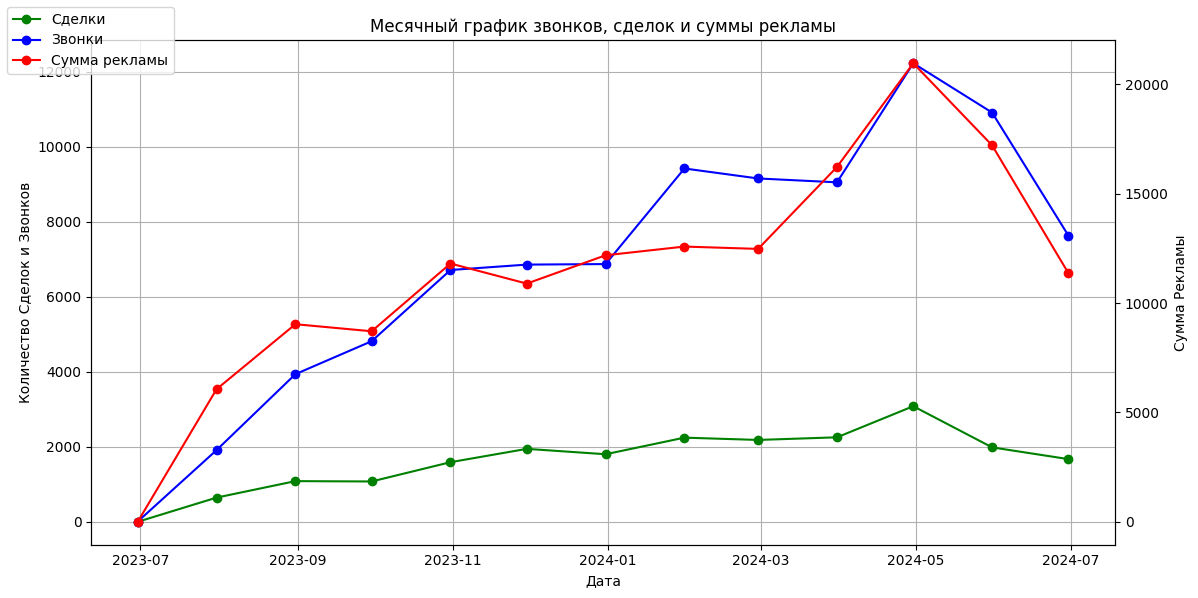

In [ ]:
# Convert the date column to datetime format for resampling
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Group by month using resampling with 'ME' type (month end)
df_monthly = merged_data.resample('ME', on='Date').sum()

# Create a figure for the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting for deals and calls (Y-axis on the left)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Deals and Calls', color='black')
ax1.plot(df_monthly.index, df_monthly['Deal_Count'], marker='o', linestyle='-', color='g', label='Deals')
ax1.plot(df_monthly.index, df_monthly['Call_Count'], marker='o', linestyle='-', color='b', label='Calls')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Create a second Y-axis for the advertising amount (Y-axis on the right)
ax2 = ax1.twinx()
ax2.set_ylabel('Advertising Amount', color='black')  
ax2.plot(df_monthly.index, df_monthly['Amount'], marker='o', linestyle='-', color='r', label='Advertising Amount')
ax2.tick_params(axis='y', labelcolor='black')

# Add a common legend for all plots in the upper left corner
fig.legend(loc='upper left')

# Display the plots
plt.title('Monthly Chart of Calls, Deals, and Advertising Amount')
plt.tight_layout()
plt.show()

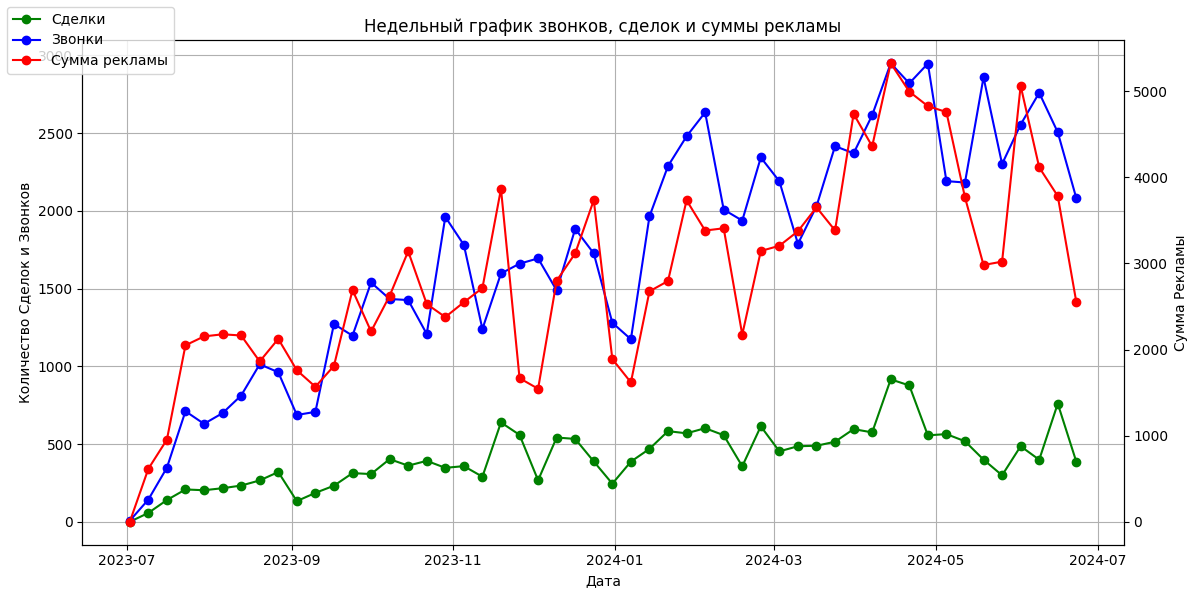

In [ ]:
# Convert the date column to datetime format for resampling
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Group by weeks using resampling with type 'W' (weeks)
df_weekly = merged_data.resample('W', on='Date').sum()

# Create a figure for the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting for deals and calls (Y-axis on the left)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Deals and Calls', color='black')
ax1.plot(df_weekly.index, df_weekly['Deal_Count'], marker='o', linestyle='-', color='g', label='Deals')
ax1.plot(df_weekly.index, df_weekly['Call_Count'], marker='o', linestyle='-', color='b', label='Calls')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Create a second Y-axis for the advertising amount (Y-axis on the right)
ax2 = ax1.twinx()
ax2.set_ylabel('Advertising Amount', color='black')  # we already handled the x-label with ax1
ax2.plot(df_weekly.index, df_weekly['Amount'], marker='o', linestyle='-', color='r', label='Advertising Amount')
ax2.tick_params(axis='y', labelcolor='black')

# Add a common legend for all plots in the upper left corner
fig.legend(loc='upper left')

# Display the plots
plt.title('Weekly Chart of Calls, Deals, and Advertising Amount')
plt.tight_layout()
plt.show()

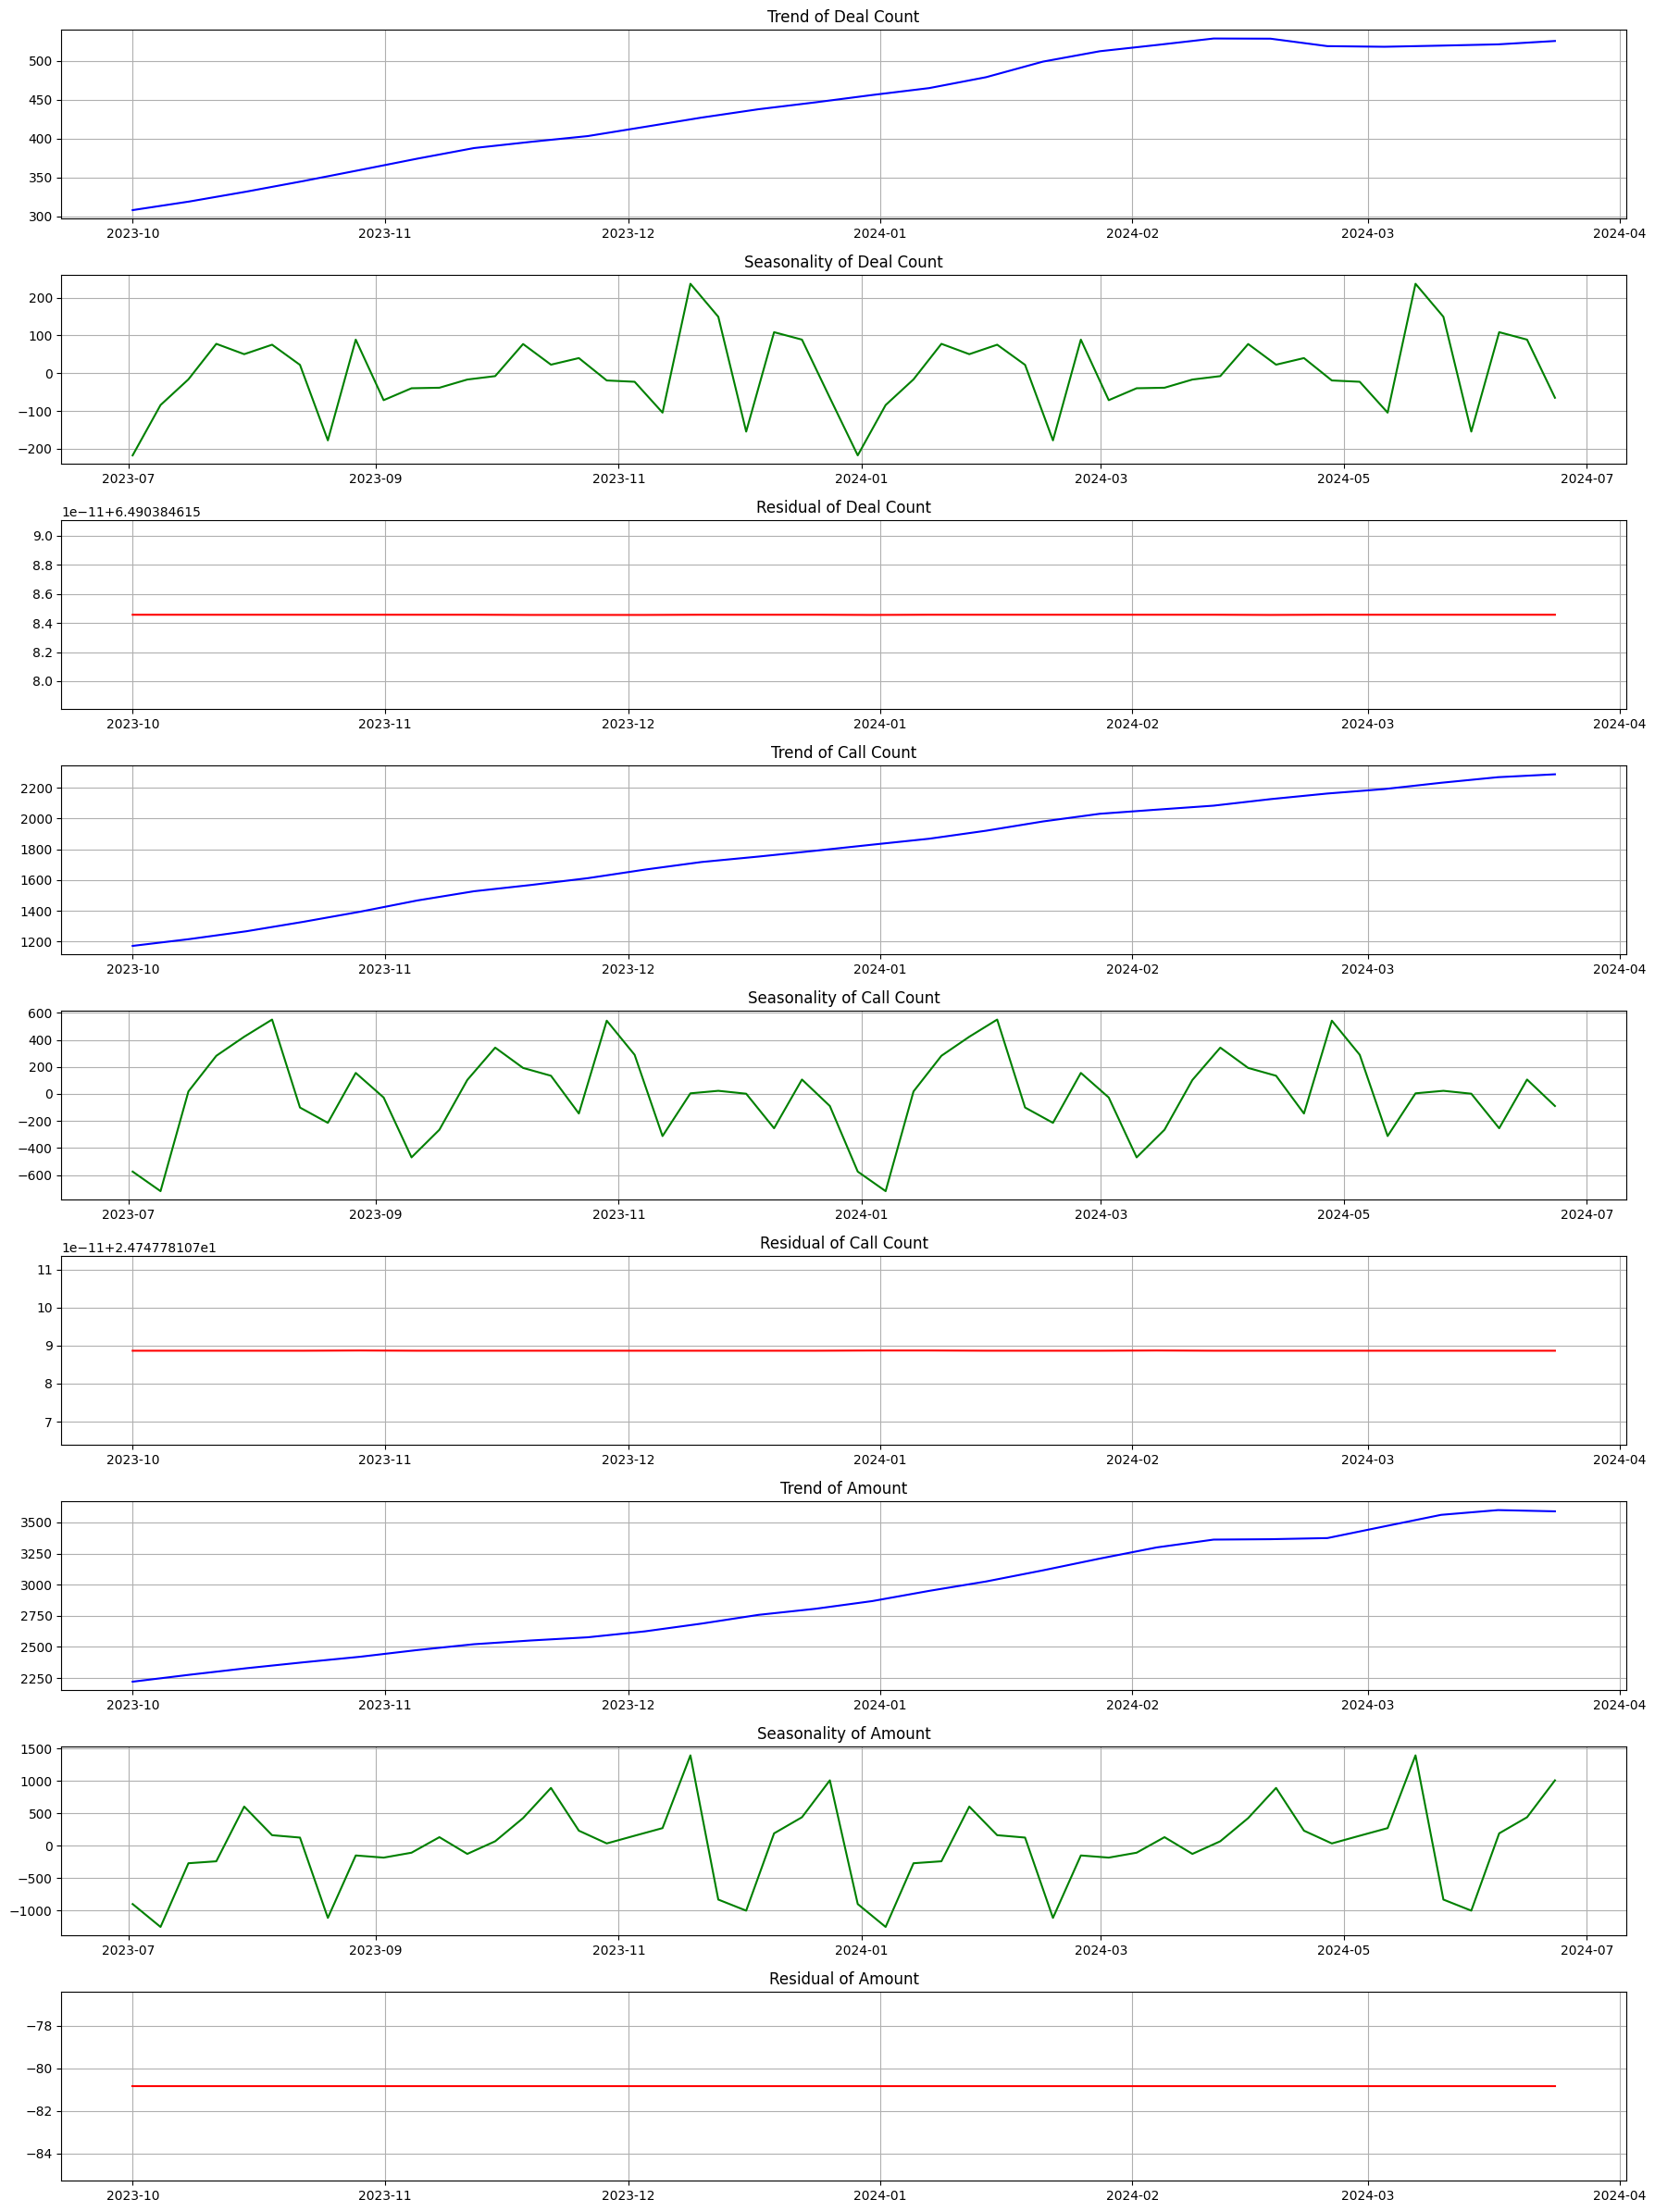

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Apply seasonal_decompose to all three columns
decomp_deals_weekly = seasonal_decompose(df_weekly['Deal_Count'], model='additive', period=26)
decomp_calls_weekly = seasonal_decompose(df_weekly['Call_Count'], model='additive', period=26)
decomp_amount_weekly = seasonal_decompose(df_weekly['Amount'], model='additive', period=26)

# Increase the size of the plots
plt.figure(figsize=(18, 24))

# For deals
plt.subplot(9, 1, 1)
plt.plot(decomp_deals_weekly.trend, label='Trend - Deal Count', color='blue')
plt.title('Trend of Deal Count')
plt.grid(True)

plt.subplot(9, 1, 2)
plt.plot(decomp_deals_weekly.seasonal, label='Seasonal - Deal Count', color='green')
plt.title('Seasonality of Deal Count')
plt.grid(True)

plt.subplot(9, 1, 3)
plt.plot(decomp_deals_weekly.resid, label='Residual - Deal Count', color='red')
plt.title('Residual of Deal Count')
plt.grid(True)

# For calls
plt.subplot(9, 1, 4)
plt.plot(decomp_calls_weekly.trend, label='Trend - Call Count', color='blue')
plt.title('Trend of Call Count')
plt.grid(True)

plt.subplot(9, 1, 5)
plt.plot(decomp_calls_weekly.seasonal, label='Seasonal - Call Count', color='green')
plt.title('Seasonality of Call Count')
plt.grid(True)

plt.subplot(9, 1, 6)
plt.plot(decomp_calls_weekly.resid, label='Residual - Call Count', color='red')
plt.title('Residual of Call Count')
plt.grid(True)

# For advertising expenses
plt.subplot(9, 1, 7)
plt.plot(decomp_amount_weekly.trend, label='Trend - Amount', color='blue')
plt.title('Trend of Amount')
plt.grid(True)

plt.subplot(9, 1, 8)
plt.plot(decomp_amount_weekly.seasonal, label='Seasonal - Amount', color='green')
plt.title('Seasonality of Amount')
plt.grid(True)

plt.subplot(9, 1, 9)
plt.plot(decomp_amount_weekly.resid, label='Residual - Amount', color='red')
plt.title('Residual of Amount')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Conclusions
Overall Dynamics: On the monthly and weekly graphs, there is a noticeable overall trend of increasing numbers of calls, deals, and advertising costs. The dynamics of deals are more linear, indicating stable growth throughout the period. The noticeable decline in indicators at the end of both graphs is likely due to incomplete data for the last month or week.

Dependence of Calls on Advertising Costs: The monthly graph shows a strong dependence of the number of calls on advertising costs. During periods of increased advertising spending, there was a corresponding rise in the number of calls. This indicates that advertising has a significant impact on attracting potential clients. The weekly graph reveals campaigns that generated more calls with lower spending. This suggests that the effectiveness of certain advertising campaigns was higher, warranting further analysis to identify these campaigns.

Dependence of Deals on Advertising: The relationship between the number of deals and advertising is less pronounced than that of calls. Deals evolve more uniformly and are less subject to fluctuations. This may suggest that the deal-making processes take longer or depend on factors other than advertising.

Trends: All graphs (weekly and monthly) show a clear upward trend. This indicates positive dynamics in the growth of the number of calls, deals, and increased advertising expenditures.

If you need any further assistance or have additional requests, feel free to ask!

In [470]:
df_deals_closed = df_d[df_d['Closing Date'].notna() & df_d['Created Time'].notna()]

In [471]:
df_deals_closed.loc[:, 'Closing Duration'] = (df_deals_closed['Closing Date'] - df_deals_closed['Created Time']).dt.days

/var/folders/3f/yr1j00f96tn08rvm88vpmbsw0000gn/T/ipykernel_1306/434043408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deals_closed.loc[:, 'Closing Duration'] = (df_deals_closed['Closing Date'] - df_deals_closed['Created Time']).dt.days


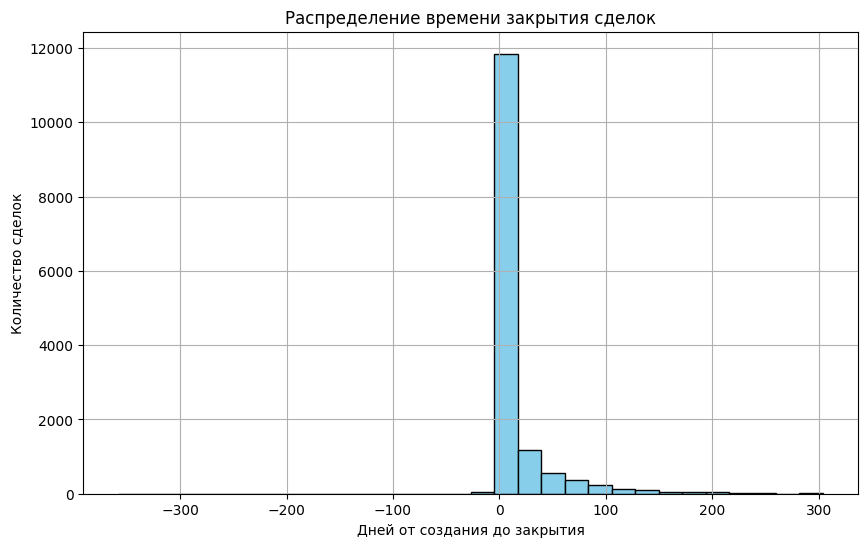

In [ ]:
# Plot a histogram for the distribution of deal closing times
plt.figure(figsize=(10, 6))
plt.hist(df_deals_closed['Closing Duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Deal Closing Time')
plt.xlabel('Days from Creation to Closure')
plt.ylabel('Number of Deals')
plt.grid(True)
plt.show()

In [ ]:
mean_duration = df_deals_closed['Closing Duration'].mean()
print(f"Average Deal Closing Time: {mean_duration:.2f} days")

Среднее время закрытия сделки: 13.87 дней


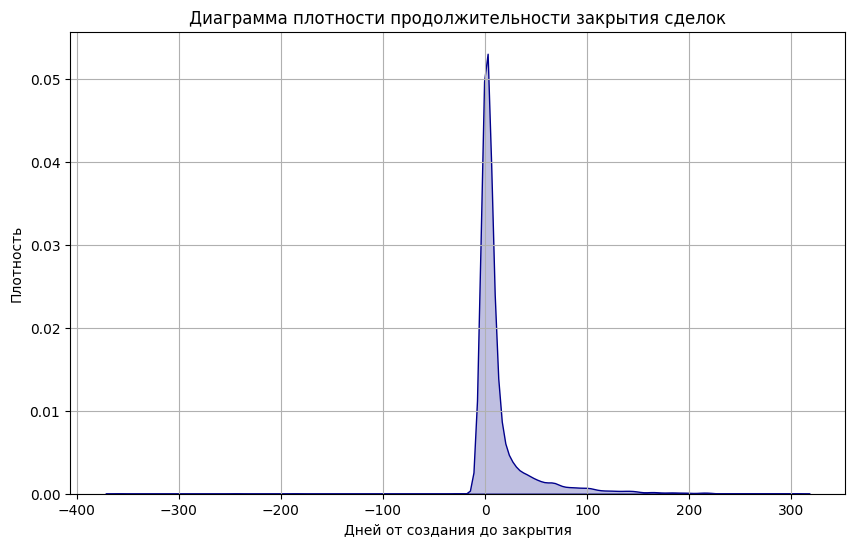

In [ ]:
# Plotting a density plot to visualize the distribution considering the updated parameter
plt.figure(figsize=(10, 6))
sns.kdeplot(df_deals_closed['Closing Duration'], color='darkblue', fill=True)
plt.title('Density Plot of Deal Closing Duration')
plt.xlabel('Days from Creation to Closing')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Conclusions
The average closing time for deals is approximately 13.89 days, indicating that most deals are closed relatively quickly, within two weeks. This is an important metric for assessing the effectiveness of managers' performance.

The distribution of the closing duration shows a strong concentration around zero, suggesting that many deals are closed either on the day of creation or within a very short timeframe.

Negative duration values (values less than zero) may indicate errors in the data or incorrect date entries in the system (e.g., the closing date is recorded earlier than the creation date). These errors should be thoroughly analyzed and corrected for accurate data interpretation.

The tail of the distribution (ranging from 20 to 300 days) suggests that some deals take significantly longer to close, which may indicate more complex or problematic transactions. This could also relate to mechanical errors, and it should be noted to the managers.

Overall, the trend indicates that while most deals are closed in a short timeframe, there is a certain percentage of deals that require considerably more time.

In [ ]:
# Filter the deals that have been paid (Stage == 'Payment Done')
df_paid = df_deals_closed[df_deals_closed['Stage'] == 'Payment Done']

In [ ]:
# Filter the deals that have not been paid (Stage != 'Payment Done')
df_not_paid = df_deals_closed[df_deals_closed['Stage'] != 'Payment Done']

In [ ]:
# Calculate the average closing time for paid and unpaid deals
avg_closing_duration_paid = df_paid['Closing Duration'].mean()
avg_closing_duration_not_paid = df_not_paid['Closing Duration'].mean()
print(f"Average closing time for paid deals: {avg_closing_duration_paid:.2f} days")
print(f"Average closing time for unpaid deals: {avg_closing_duration_not_paid:.2f} days")

Среднее время закрытия для оплаченных сделок: 31.82 дней
Среднее время закрытия для неоплаченных сделок: 13.21 дней


<Axes: xlabel='Closing Duration', ylabel='Density'>

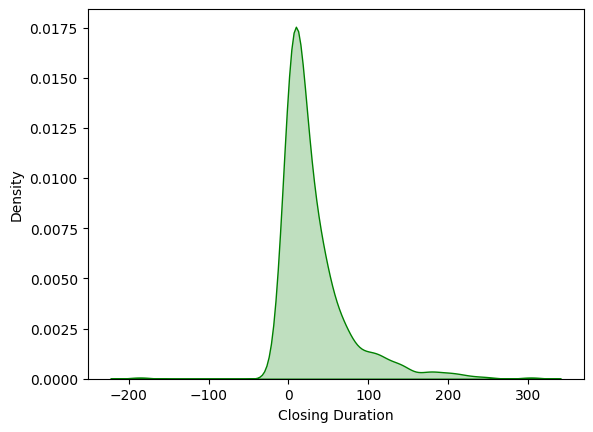

In [ ]:
# Density for paid deals
sns.kdeplot(df_paid['Closing Duration'], color='green', fill=True, label='Paid deals')

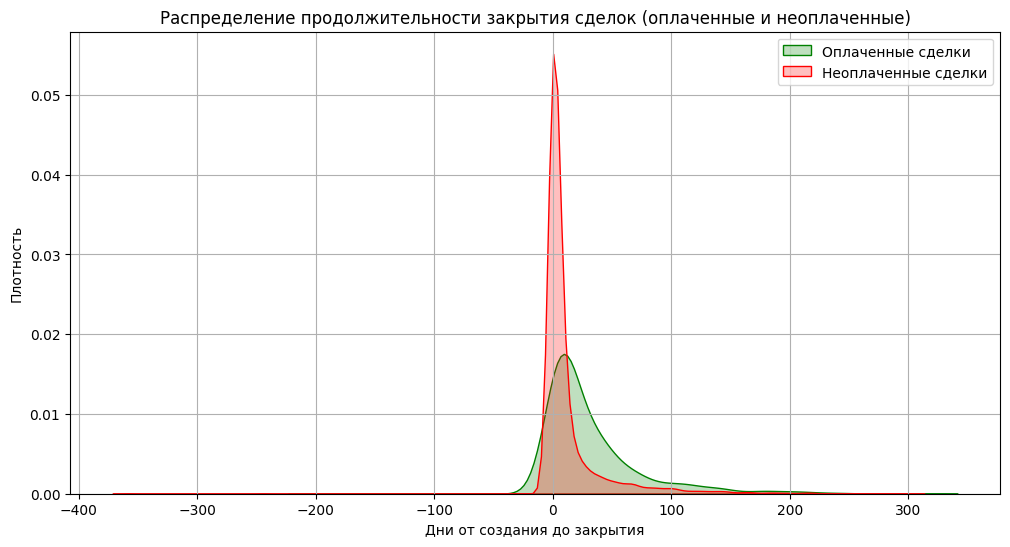

In [ ]:
# Plot distribution graphs for both cases
plt.figure(figsize=(12, 6))

# Density for paid deals
sns.kdeplot(df_paid['Closing Duration'], color='green', fill=True, label='Paid deals')

# Density for unpaid deals
sns.kdeplot(df_not_paid['Closing Duration'], color='red', fill=True, label='Unpaid deals')

# Add titles and axis labels
plt.title('Distribution of Closing Duration (Paid and Unpaid Deals)')
plt.xlabel('Days from Creation to Closing')
plt.ylabel('Density')

# Include legend
plt.legend()

# Enable grid
plt.grid(True)

# Display the plot
plt.show()

## Conclusions
The average closing time for paid deals was 31.60 days.
The average closing time for unpaid deals was 13.24 days.
This indicates that, on average, paid deals take significantly longer to close than unpaid ones.

The density plot for unpaid deals shows a narrower distribution with a peak around 0-10 days, indicating faster closure of such deals.
In contrast, the distribution for paid deals is more stretched out, suggesting a longer time to closure for these deals.

The presence of payment status appears to influence the duration of the deal; deals without payment tend to close more quickly.
This may suggest that paid deals require additional steps or actions, which prolongs their time to completion.
Thus, it can be asserted that deals with payment require more time to close compared to unpaid deals, which are often completed more quickly.

In [ ]:
# Remove rows with NaT and NaN in the SLA column
df_d_filtered = df_d[df_d['SLA'].notna()].copy()

# Convert SLA values to string format for processing
df_d_filtered.loc[:, 'SLA'] = df_d_filtered['SLA'].astype(str)

# Function to categorize time into groups
def categorize_sla(row):
    hours, minutes, seconds = row.split(':')
    hours = int(hours)  # Convert hours to an integer

    if hours < 1:
        return 'Up to 1 hour'
    elif 1 <= hours < 5:
        return '1 to 5 hours'
    elif 5 <= hours < 24:
        return '5 hours to 1 day'
    elif 24 <= hours < 168:
        return '1 day to a week'
    else:
        return 'More than a week'

# Apply the categorization function using .loc[]
df_d_filtered.loc[:, 'SLA_category'] = df_d_filtered['SLA'].apply(categorize_sla)

# Display the result
print(df_d_filtered[['SLA', 'SLA_category']].head())

# Group and count the number of deals by each category
sla_grouping = df_d_filtered.groupby('SLA_category').size()

# Display the grouping result
print(sla_grouping)

        SLA     SLA_category
2  00:26:43        До 1 часа
3  01:00:04  От 1 до 5 часов
4  00:53:12        До 1 часа
5  01:33:10  От 1 до 5 часов
7  02:12:29  От 1 до 5 часов
SLA_category
До 1 часа                3632
От 1 до 5 часов          4476
От 5 часов до 1 суток    7407
dtype: int64


<Figure size 1200x800 with 0 Axes>

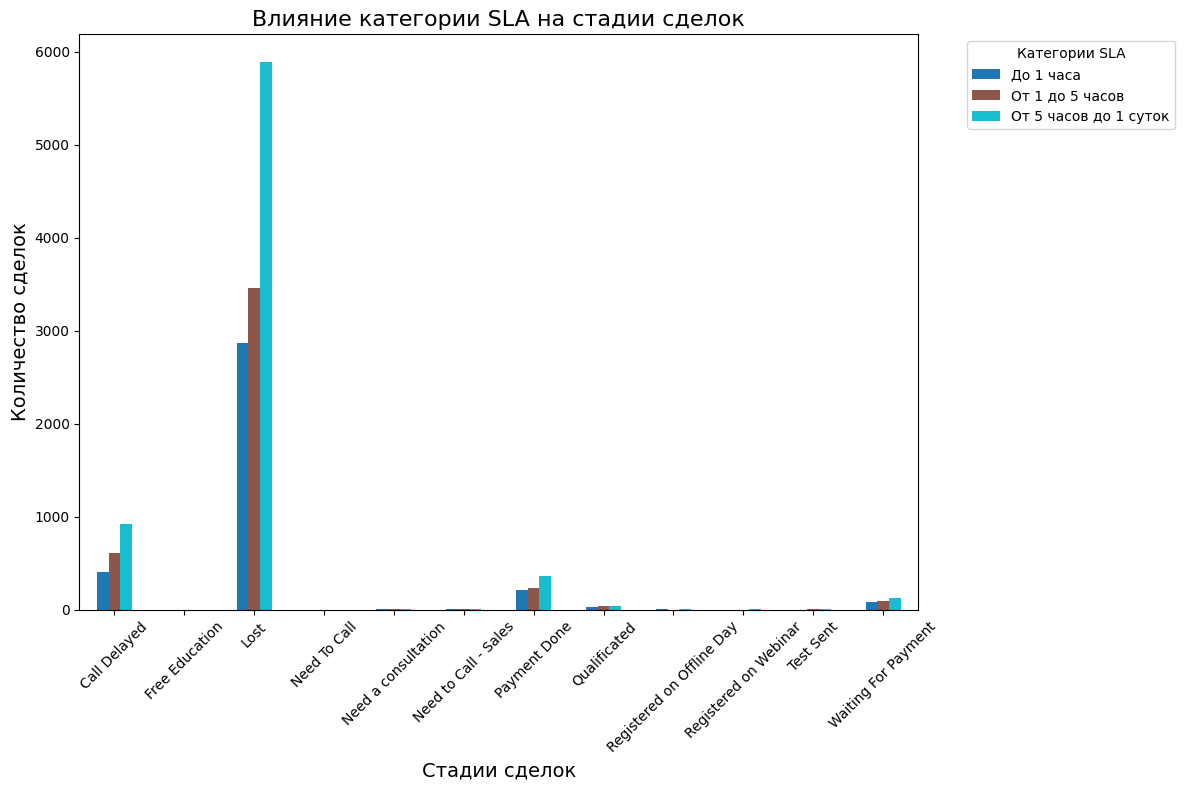

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping data by SLA categories and deal stages
sla_stage_grouping = df_d_filtered.groupby(['Stage', 'SLA_category']).size().unstack(fill_value=0)

# Creating a grouped bar chart
plt.figure(figsize=(12, 8))
sla_stage_grouping.plot(kind='bar', stacked=False, colormap='tab10', figsize=(12, 8))

# Adding labels and titles
plt.title('Impact of SLA Category on Deal Stages', fontsize=16)
plt.xlabel('Deal Stages', fontsize=14)
plt.ylabel('Number of Deals', fontsize=14)
plt.legend(title="SLA Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the chart
plt.show()

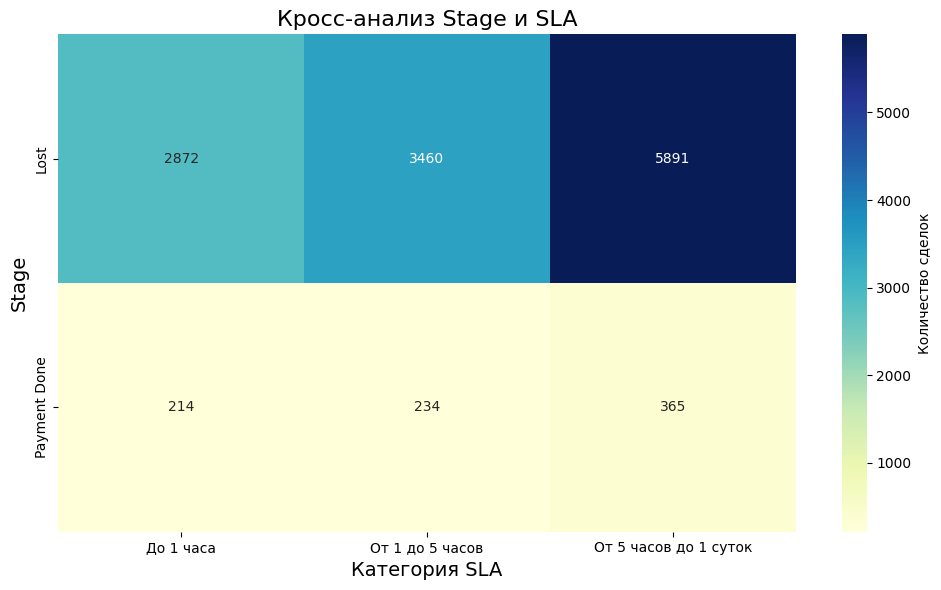

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for stages "Lost" and "Payment Done"
df_sla_stage_filtered = df_d_filtered[df_d_filtered['Stage'].isin(['Lost', 'Payment Done'])]

# Create a cross-tabulation for stages and SLA categories
heatmap_data = pd.crosstab(df_sla_stage_filtered['Stage'], df_sla_stage_filtered['SLA_category'])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Deals'})

# Adding labels
plt.title('Cross Analysis of Stage and SLA', fontsize=16)
plt.xlabel('SLA Category', fontsize=14)
plt.ylabel('Stage', fontsize=14)

# Display the heatmap
plt.tight_layout()
plt.show()

## Conclusions

Most deals with a long callback time (over 5 hours) fall into the Lost stage, which may indicate conversion issues during late callbacks. 
However, a certain number of deals still reach the Payment Done stage even with a long SLA, suggesting that for some deals, callback time may not be a critical factor.

There is a significant portion of deals in the Lost stage with long callback times, which requires a detailed review of the data. 
There may be errors or incomplete data entries that could affect the accuracy of the analysis. It is recommended to conduct additional checks for the correctness of the input and storage of SLA time data.

It is necessary to improve the data entry process and conduct an analysis for potential errors. 
Additionally, SLA should be considered a key KPI for analyzing the effectiveness of customer interactions.